# Import des données

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [2]:
train = pd.read_csv('../DSnet_MAIF/ech_apprentissage.csv',encoding='utf-8',sep=';',low_memory=False)
test = pd.read_csv('../DSnet_MAIF/ech_test.csv',encoding='utf-8',sep=';')

In [3]:
pd.set_option("display.max_columns", 9999) # permet de voir toutes les colonnes
pd.set_option("display.max_rows", 200) # permet de voir toutes les colonnes
train.head(3)

,id,annee_naissance,annee_permis,marque,puis_fiscale,anc_veh,codepostal,energie_veh,kmage_annuel,crm,profession,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,prime_tot_ttc
0,1,1986.0,2006.0,RENAULT,4,1,1034,gpl,2924,68,"enseignant, formateur, chercheur",10.0,1,372,0,1,A,1,B1,60,155,1,855,3,N,1,1,1,27,0,0,0,1,254.75
1,2,1986.0,2006.0,RENAULT,8,2,1034,gpl,11580,50,"enseignant, formateur, chercheur",10.0,1,372,0,1,B,7,H1,115,175,2,1490,5,N,2,1,1,28,0,0,0,1,259.89
2,3,1982.0,2001.0,RENAULT,7,2,1034,gpl,7149,95,"enseignant, formateur, chercheur",15.0,2,372,0,2,C,10,M1,90,170,2,1278,5,N,3,1,1,29,0,0,0,1,431.65


# Analyse descriptive

### Distribution des donnees

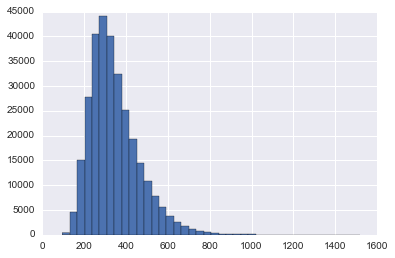

In [4]:
# Distribution des prix
train['prime_tot_ttc'].hist(bins=40)

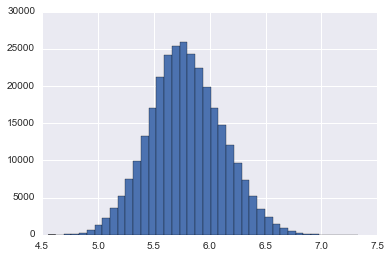

In [5]:
# Distribution du log des prix
# On prend le log des prix car sa distribution est plus proche d'une gaussienne
train['logprime'] = train['prime_tot_ttc'].apply(np.log)
train['logprime'].hist(bins=40)

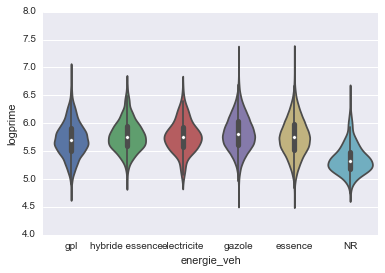

In [6]:
# Influence sur les prix de la feature "..." : On voit que NR est plus bas
sns.violinplot(y="logprime", x="energie_veh", data=train)

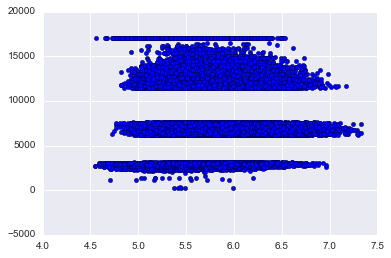

In [61]:
plt.scatter(train.logprime, train['kmage_annuel'])

ERROR! Session/line number was not unique in database. History logging moved to new session 99


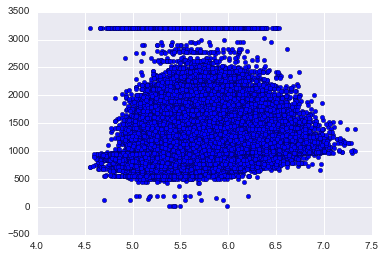

In [60]:
plt.scatter(train.logprime, train['var12'])

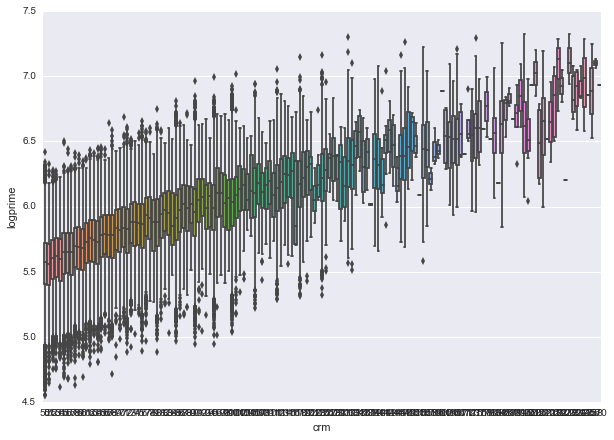

In [50]:
# Influence sur les prix de la feature "..."
plt.figure(figsize=[10,7])
sns.boxplot(y="logprime", x="crm", data=train)

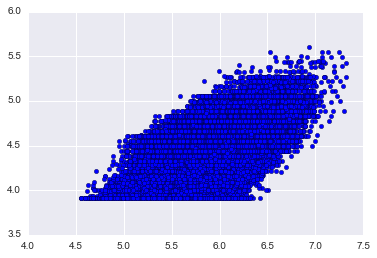

In [55]:
plt.scatter(train.logprime, train['crm'].apply(np.log))

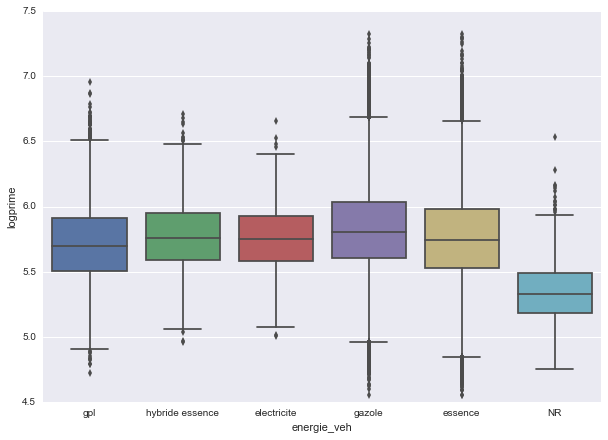

In [7]:
# Influence sur les prix de la feature "..."
plt.figure(figsize=[10,7])
sns.boxplot(y="logprime", x="energie_veh", data=train)

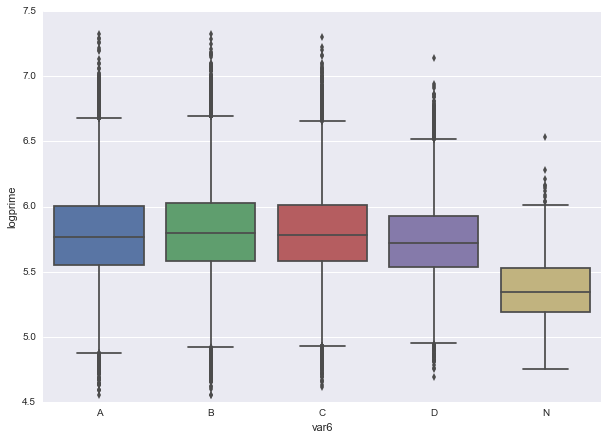

In [102]:
# Influence sur les prix de la feature "..."
plt.figure(figsize=[10,7])
sns.boxplot(y="logprime", x="var6", data=train)

# Preparation des donnees

In [62]:
# On rassemble pour le feature engineering
df = pd.concat([train,test])
df.tail(5)

,anc_veh,annee_naissance,annee_permis,codepostal,crm,energie_veh,id,kmage_annuel,logprime,marque,prime_tot_ttc,profession,puis_fiscale,var1,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var2,var20,var21,var22,var3,var4,var5,var6,var7,var8,var9
29995,33,1978.0,1998.0,97414,50,gazole,329996,7563,NaN,MERCEDES,NaN,artisan,8,18.0,220,33,1430,2,N,0,4,1,18,0,2,0,0,1,272,1,1,B,5,M2,143
29996,38,1987.0,2006.0,97411,50,gazole,329997,7224,NaN,ALFA ROMEO,NaN,"agent, employe",8,10.0,209,38,1305,4,N,1,4,1,19,0,2,0,0,1,272,2,1,A,1,M2,140
29997,13,1991.0,2010.0,97411,100,gazole,329998,6511,NaN,PEUGEOT,NaN,"agent, employe",5,6.0,163,13,1060,3,N,0,3,1,8,0,5,1,1,1,372,3,2,B,1,B2,70
29998,1,1972.0,1991.0,97411,64,essence,329999,6308,NaN,MITSUBISHI,NaN,"enseignant, formateur, chercheur",6,25.0,0,1,995,4,N,1,1,1,8,0,5,1,1,1,372,2,1,A,1,M1,75
29999,13,1984.0,2003.0,97411,100,essence,330000,3008,NaN,OPEL,NaN,"agent, employe",4,13.0,155,13,905,3,N,0,3,1,9,0,2,1,1,1,372,0,2,A,1,B2,58


In [63]:
# Creation features : sum of binary
list_bin = ['var15','var17','var19','var20','var21','var22']
df.loc[:,'sum_bin'] = df[list_bin].sum(axis=1)

# Creation log de crm
df['logcrm'] = df['crm'].apply(np.log)

In [64]:
# On cree une feature qui est le nombre de lettre de substances
df['nb_charact_profession'] = df.profession.map(len)
df['nb_profession'] = df.profession.map(lambda x:len(x.split(',')))

In [65]:
# On nettoie df
df.isnull().any()

anc_veh                  False
annee_naissance           True
annee_permis              True
codepostal               False
crm                      False
energie_veh              False
id                       False
kmage_annuel             False
logprime                  True
marque                   False
prime_tot_ttc             True
profession               False
puis_fiscale             False
var1                      True
var10                    False
var11                    False
var12                    False
var13                    False
var14                    False
var15                    False
var16                    False
var17                    False
var18                    False
var19                    False
var2                     False
var20                    False
var21                    False
var22                    False
var3                     False
var4                     False
var5                     False
var6                     False
var7    

In [66]:
print sum(df.annee_naissance.isnull())
print sum(df.annee_permis.isnull())
print sum(df.var1.isnull())

307
307
307


In [67]:
df.loc[df.annee_naissance.isnull(),'annee_naissance'] =  df.annee_naissance.mode()[0]
df.loc[df.annee_permis.isnull(),'annee_permis'] =  df.annee_permis.mode()[0]
df.loc[df.var1.isnull(),'var1'] =  df.var1.mode()[0]

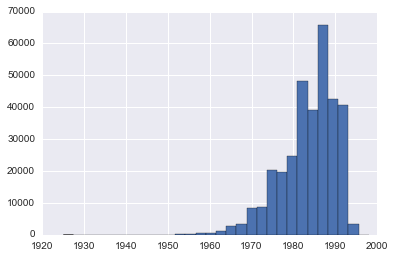

In [109]:
df.annee_naissance.hist(bins=30)

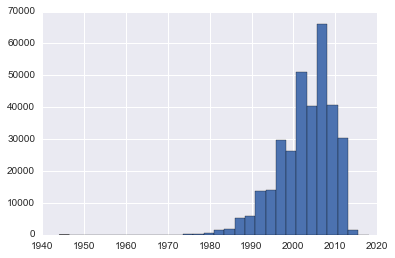

In [111]:
df.annee_permis.hist(bins=30)

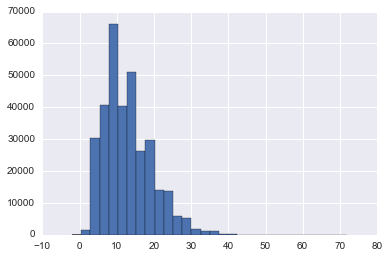

In [70]:
df.var1.hist(bins=30)

In [71]:
#sns.pairplot(df)

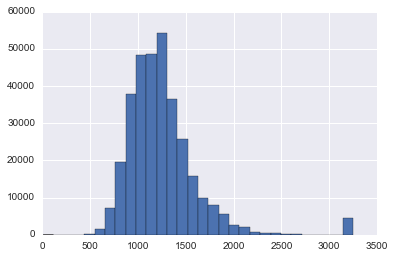

In [105]:
df.var12.hist(bins=30)

In [72]:
# TF IDF sur substances
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0, stop_words = 'english')
corp = df.profession
tfidf_matrix =  tf.fit_transform(corp)
print tfidf_matrix.shape    # on regarde si on peut traiter la matrice ou si on doit SVD
dense = pd.DataFrame(data=tfidf_matrix.todense(), columns=tf.get_feature_names())
list_feature_name = df.columns.tolist() + dense.columns.tolist()
df_dense = pd.DataFrame(data=np.concatenate((np.array(df),np.array(dense)), axis=1), columns=list_feature_name)
df_dense.head(2)

(330000, 41)


,anc_veh,annee_naissance,annee_permis,codepostal,crm,energie_veh,id,kmage_annuel,logprime,marque,prime_tot_ttc,profession,puis_fiscale,var1,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var2,var20,var21,var22,var3,var4,var5,var6,var7,var8,var9,sum_bin,logcrm,nb_charact_profession,nb_profession,agent,agriculteur,animateur,artisan,arts,au,cadre,chef,chercheur,commercant,contremaitre,demandeur,des,du,educateur,emploi,employe,enseignant,entreprise,et,etudiant,exploitant,femme,formateur,foyer,homme,information,ingenieur,intermediaire,la,liberale,maitrise,moniteur,ou,ouvrier,profession,sante,social,spectacles,technicien,travail
0,1,1986,2006,1034,68,gpl,1,2924,5.54028,RENAULT,254.75,"enseignant, formateur, chercheur",4,10,155,1,855,3,N,1,1,1,27,0,1,0,0,1,372,0,1,A,1,B1,60,3,4.21951,32,3,0,0,0,0,0,0,0,0,0.57735,0,0,0,0,0,0,0,0,0.57735,0,0,0,0,0,0.57735,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1986,2006,1034,50,gpl,2,11580,5.56026,RENAULT,259.89,"enseignant, formateur, chercheur",8,10,175,2,1490,5,N,2,1,1,28,0,1,0,0,1,372,0,1,B,7,H1,115,4,3.91202,32,3,0,0,0,0,0,0,0,0,0.57735,0,0,0,0,0,0,0,0,0.57735,0,0,0,0,0,0.57735,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [73]:
df.head(2)

,anc_veh,annee_naissance,annee_permis,codepostal,crm,energie_veh,id,kmage_annuel,logprime,marque,prime_tot_ttc,profession,puis_fiscale,var1,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var2,var20,var21,var22,var3,var4,var5,var6,var7,var8,var9,sum_bin,logcrm,nb_charact_profession,nb_profession
0,1,1986.0,2006.0,1034,68,gpl,1,2924,5.540283,RENAULT,254.75,"enseignant, formateur, chercheur",4,10.0,155,1,855,3,N,1,1,1,27,0,1,0,0,1,372,0,1,A,1,B1,60,3,4.219508,32,3
1,2,1986.0,2006.0,1034,50,gpl,2,11580,5.560258,RENAULT,259.89,"enseignant, formateur, chercheur",8,10.0,175,2,1490,5,N,2,1,1,28,0,1,0,0,1,372,0,1,B,7,H1,115,4,3.912023,32,3


### Dummification

In [74]:
# Certains string se cachent dans des var cont donc on les met dans feat_bin pour label encoder
# features à travailler
df.dtypes

anc_veh                    int64
annee_naissance          float64
annee_permis             float64
codepostal                object
crm                        int64
energie_veh               object
id                         int64
kmage_annuel               int64
logprime                 float64
marque                    object
prime_tot_ttc            float64
profession                object
puis_fiscale               int64
var1                     float64
var10                      int64
var11                      int64
var12                      int64
var13                      int64
var14                     object
var15                      int64
var16                     object
var17                      int64
var18                      int64
var19                      int64
var2                       int64
var20                      int64
var21                      int64
var22                      int64
var3                       int64
var4                       int64
var5      

In [75]:
feat_drop = ['id','prime_tot_ttc','profession']

feat_bin = ['codepostal','var14','var16','var6','var7','var8']

feat_cat = ['energie_veh','marque','var14','var6','var8']

feat_num = [col for col in df_dense.columns if col not in feat_drop and col not in feat_cat and col not in feat_bin]

df_dense = df_dense.drop(feat_drop, 1)

In [76]:
# pour les featues categorielles (dummification)
X_dummies = pd.DataFrame()
X_dummies[feat_cat] = df_dense[feat_cat]
X_dummies = pd.get_dummies(X_dummies)

In [77]:
# pour les features binaires (ET CATEGORIELLES ORDINALES)
X_dummies[feat_bin] = df_dense[feat_bin]
for c in feat_bin:
    le = LabelEncoder()
    le.fit(X_dummies[c])
    X_dummies[c] = le.transform(df[c])

In [78]:
# les features continues
X_dummies[feat_num] = df_dense[feat_num].convert_objects(convert_numeric=True)

/Users/Samuel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


### On separe a nouveau train et test

In [79]:
df_train = X_dummies[:train.shape[0]]
df_test = X_dummies[(X_dummies.shape[0] - test.shape[0]):]

In [80]:
target_train = df_train.logprime
df_train = df_train.drop('logprime', inplace=False, axis=1)

target_test = df_test.logprime
df_test = df_test.drop('logprime', inplace=False, axis=1)

# Creation d'un modele

### Métrique MAPE

La métrique MAPE n'étant pas disponible dans scikit-learn, nous la codons

In [81]:
# Mean Absolute Percentage Error
def mape_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Variables importantes

In [82]:
from sklearn.cross_validation import train_test_split
import time
t0 = time.time()
X_train, X_test, y_train, y_test = train_test_split(df_train, target_train, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=10,random_state=42, n_jobs=8)
rf.fit(X_train, y_train)
print("RF in %fs" % (time.time() - t0))

RF in 31.701229s


In [83]:
mape_error(np.exp(y_test),np.exp(rf.predict(X_test)))

10.549008392763318

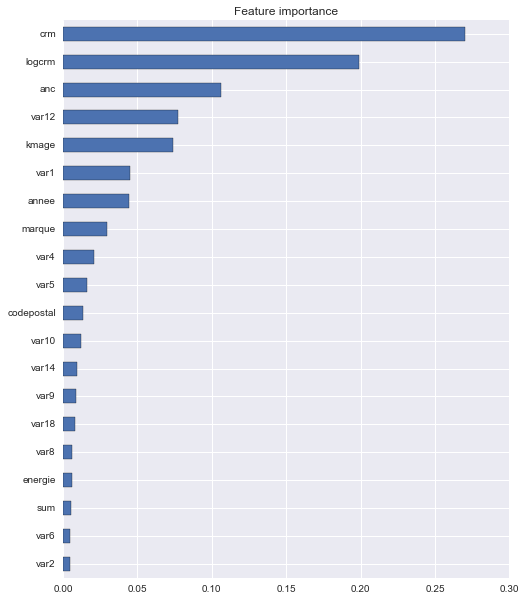

In [84]:
fi_result = pd.DataFrame(rf.feature_importances_, index=X_train.columns).T
fi_result = fi_result.T.groupby([s.split('_')[0] for s in fi_result.T.index.values]).sum().T
plt.figure(figsize=(8,10))
fi_grouped = fi_result.iloc[0].sort_values(ascending=False)
ax = fi_grouped[:20].plot(kind="barh")
plt.title('Feature importance')
ax.invert_yaxis()

### Cross validation

In [123]:
# modele Random Forest
err = 0
NBROUND = 3
for train_index, test_index in KFold(df_train.shape[0], n_folds=NBROUND, random_state=42):
    y = target_train
    X = df_train
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    rf = RandomForestRegressor(n_estimators=300, max_depth=16, min_samples_split=41,
                               min_samples_leaf=2, min_weight_fraction_leaf=0, max_features='auto',
                               max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=30, random_state=42,
                               verbose=0, warm_start=True)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    err += mape_error(np.exp(y_test), np.exp(pred))
    print mape_error(np.exp(y_test), np.exp(pred))
print "*** MAPE Error : ", err / NBROUND

1
10.795517477
10.3548889879
10.9652153809
*** MAPE Error :  10.7052072819
2
10.7892927234
10.3493408312
10.9637184285
*** MAPE Error :  10.7007839944
3
10.789969424
10.3554362034
10.9668883113
*** MAPE Error :  10.7040979796
4
10.787309278
10.3672659946
10.9721994008
*** MAPE Error :  10.7089248911
5


KeyboardInterrupt: 

best MAPE Error : 10.5652578229 avec 300 arbres

In [87]:
# modele Extra Trees
from sklearn.ensemble import ExtraTreesRegressor

err = 0
NBROUND = 3
for train_index, test_index in KFold(df_train.shape[0], n_folds=NBROUND, random_state=42):
    y = target_train
    X = df_train
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    etr = ExtraTreesRegressor(n_estimators=300, criterion='mse', max_depth=75,
                              min_samples_split=1, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                              max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=False,
                              n_jobs=30, random_state=42, verbose=0, warm_start=True)
    etr.fit(X_train, y_train)
    pred = etr.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    err += mape_error(np.exp(y_test), np.exp(pred))
    print mape_error(np.exp(y_test), np.exp(pred))
print "*** MAPE Error : ", err / NBROUND

9.97715906631
10.5502012355
9.97340404086
10.2707139352
10.2940810124
*** MAPE Error :  10.2131118581


best MAPE Error : 10.2368931362 avec 300 arbres

In [98]:
# modele XGB
import xgboost as xgb

for i in range(0,5):
    err = 0
    NBROUND = 3
    print i
    for train_index, test_index in KFold(df_train.shape[0], n_folds=NBROUND, random_state=42):
        y = target_train
        X = df_train
        X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        clf = xgb.XGBRegressor(max_depth=13 , n_estimators=1000, learning_rate=0.063, 
                               nthread=30, subsample=0.6+i*0.05, colsample_bytree=0.6,
                               min_child_weight = 1, seed=42)
        clf.fit(X_train, y_train, early_stopping_rounds=150,
                eval_metric='map', eval_set=[(X_test, y_test)],
                verbose=False)
        pred = clf.predict(X_test)
        # ne pas oublier de reprendre l'exponentielle de la prédiction
        err += mape_error(np.exp(y_test), np.exp(pred))
        print mape_error(np.exp(y_test), np.exp(pred))
    print "*** MAPE Error : ", err / NBROUND

1
9.67791396314
8.90274998355


KeyboardInterrupt: 

best MAPE Error : 9.24712142932

In [88]:
# modele blend
err = 0
NBROUND = 5
for train_index, test_index in KFold(df_train.shape[0], n_folds=NBROUND, random_state=42):
    y = target_train
    X = df_train
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = xgb.XGBRegressor(max_depth=8, n_estimators=5000, learning_rate=0.05, 
                           nthread=8, subsample=0.8, colsample_bytree=0.6,
                           min_child_weight = 1, seed=42)
    rf = RandomForestRegressor(n_estimators=200, max_depth=50, min_samples_split=2,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                               max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=8, random_state=42,
                               verbose=0, warm_start=True)
    etr = ExtraTreesRegressor(n_estimators=200, criterion='mse', max_depth=50,
                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                              max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=False,
                              n_jobs=8, random_state=42, verbose=0, warm_start=True)
    clf.fit(X_train, y_train, early_stopping_rounds=150, eval_metric='map', eval_set=[(X_test, y_test)], verbose=False)
    rf.fit(X_train, y_train)
    etr.fit(X_train, y_train)
    
    pred = 0.85*clf.predict(X_test) + 0.1*etr.predict(X_test) + 0.05*rf.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    err += mape_error(np.exp(y_test), np.exp(pred))
    print mape_error(np.exp(y_test), np.exp(pred))
print "*** MAPE Error : ", err / NBROUND

9.48425695318


KeyboardInterrupt: 

best MAPE Error : 9.71038965677

# Calcul des predictions et soumission

In [99]:
rf = RandomForestRegressor(n_estimators=300, max_depth=16, min_samples_split=41,
                           min_samples_leaf=2, min_weight_fraction_leaf=0, max_features='auto',
                           max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=30, random_state=42,
                           verbose=0, warm_start=True)    
    
etr = ExtraTreesRegressor(n_estimators=300, criterion='mse', max_depth=75,
                          min_samples_split=1, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                          max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=False,
                          n_jobs=30, random_state=42, verbose=0, warm_start=True)

clf = xgb.XGBRegressor(max_depth=13, n_estimators=1000, learning_rate=0.063, 
                       nthread=30, subsample=0.8, colsample_bytree=0.6,
                       min_child_weight = 1, seed=42)
# On entraine de nouveau le modèle, cette fois sur l'intégralité des données
rf.fit(df_train, target_train)
etr.fit(df_train, target_train)
clf.fit(df_train, target_train, early_stopping_rounds=150, eval_metric='map', eval_set=[(X_test, y_test)], verbose=False)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.07, max_delta_step=0, max_depth=13,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=8,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.8)

In [100]:
# Blend
a = 0.1
b = 0.2
c = 0.7

predictions = a*np.exp(rf.predict(df_test)) + b*np.exp(etr.predict(df_test)) + c*np.exp(clf.predict(df_test))

pd.DataFrame(predictions, index=test['id']).to_csv('soumission.csv', header=['COTIS'], sep = ';')

Vous etes maintenant pret ? Faites votre premiere soumission en uplodant le fichier `soumission.csv` sur [Datascience.net](http://www.datascience.net)

Pistes d'améliorations :
- feature engineering
- blend ( extra trees , RF , XGB ) avec pondération à trouver par cross val
- staking (coefficienter certaines réponses de certains weak learner fait avec juste certaines variables)